If the google colab is used

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import scipy.io as sio
import torch
import numpy as np
import torch.utils.data as utils
from __future__ import print_function
from __future__ import division
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from torch import optim
from sklearn import metrics

Paths to files must be replaced to system specific ones.

In [0]:
train_X = sio.loadmat('gdrive/My Drive/BCI_project/Band-passed 10-14Hz, splitted data 75-350 (with CSP)/train_X_csp.mat')['train_X_csp']
train_y = sio.loadmat('gdrive/My Drive/BCI_project/Band-passed 10-14Hz, splitted data 75-350 (with CSP)/train_y.mat')['train_y_csp']
 
test_X = sio.loadmat('gdrive/My Drive/BCI_project/Band-passed 10-14Hz, splitted data 75-350 (with CSP)/test_X_csp.mat')['test_X_csp']
test_y = sio.loadmat('gdrive/My Drive/BCI_project/Band-passed 10-14Hz, splitted data 75-350 (with CSP)/test_y.mat')['test_y']

train_X = np.expand_dims(train_X, axis=0)
train_X = np.moveaxis(train_X, -1, 0)

test_X = np.expand_dims(test_X, axis=0)
test_X = np.moveaxis(test_X, -1, 0)

train_y = train_y[0]
test_y = test_y[0]

train_y = train_y.T
test_y = test_y.T

In [0]:
X_train_list = []
for i in range(len(train_X)):
    X_train_list.append(train_X[i])
X_test_list = []
for i in range(len(test_X)):
    X_test_list.append(test_X[i])

tensor_X_train = torch.stack([torch.FloatTensor(i) for i in X_train_list]) # transform to torch tensors
tensor_y_train = torch.Tensor(train_y)

tensor_X_test = torch.stack([torch.FloatTensor(i) for i in X_test_list]) # transform to torch tensors
tensor_y_test = torch.Tensor(test_y)

In [0]:
train_dataset = utils.TensorDataset(tensor_X_train, tensor_y_train)
train_loader = utils.DataLoader(train_dataset, batch_size=32, num_workers=1)

test_dataset = utils.TensorDataset(tensor_X_test, tensor_y_test)
test_loader = utils.DataLoader(test_dataset, batch_size=32, num_workers=1)


In [0]:
def conv_calc(w,k,p,s):
    o = (w-k+2*p)/s + 1      #k-filter size, w-height,width p-padding s- stride
    return o
conv_calc(4,3,0,1)

2.0

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1,1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1,1)
        #self.fc1 = nn.Linear(8672, 2)
        self.fc1 = nn.Linear(64*6*275, 2)
        
        self.fc2 = nn.Linear(100,2)
        self.drop = nn.Dropout(p = 0.5)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = x.view(-1, 64*6*275)
        x = self.drop(x)
        return self.fc1(x)  

In [0]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=105600, out_features=2, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history = [] 
    epoch_number = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = []
    test_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        test_loss = 0.0

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_number.append(epoch)    

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs
                labels = labels

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                  
                    outputs = model(inputs.float())
                    
                    loss = criterion(outputs, labels.long())
                    
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                losses.append(epoch_loss)
            else:
                test_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, epoch_number, train_acc_history, losses, test_losses

In [0]:
dataloaders_dict = {"train": train_loader, "val": test_loader}

In [0]:
params_to_update = net.parameters()
optimizer_ft = optim.Adam(params_to_update, lr=3e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.1, patience=5, verbose=True)
mod, val, epo, trainig, losses, test_losses = train_model(net, dataloaders_dict, criterion, optimizer_ft)

Epoch 0/24
----------
train Loss: 1.5282 Acc: 0.5918
val Loss: 0.6379 Acc: 0.6339

Epoch 1/24
----------
train Loss: 0.6301 Acc: 0.6340
val Loss: 0.6184 Acc: 0.6447

Epoch 2/24
----------
train Loss: 0.6122 Acc: 0.6528
val Loss: 0.6234 Acc: 0.6364

Epoch 3/24
----------
train Loss: 0.5965 Acc: 0.6608
val Loss: 0.6219 Acc: 0.6443

Epoch 4/24
----------
train Loss: 0.5893 Acc: 0.6717
val Loss: 0.6228 Acc: 0.6389

Epoch 5/24
----------
train Loss: 0.5756 Acc: 0.6796
val Loss: 0.6266 Acc: 0.6406

Epoch 6/24
----------
train Loss: 0.5681 Acc: 0.6872
val Loss: 0.6383 Acc: 0.6327

Epoch 7/24
----------
train Loss: 0.5596 Acc: 0.6881
val Loss: 0.6474 Acc: 0.6289
Epoch     7: reducing learning rate of group 0 to 3.0000e-04.

Epoch 8/24
----------
train Loss: 0.5254 Acc: 0.7185
val Loss: 0.6405 Acc: 0.6310

Epoch 9/24
----------
train Loss: 0.5161 Acc: 0.7232
val Loss: 0.6449 Acc: 0.6331

Epoch 10/24
----------
train Loss: 0.4957 Acc: 0.7467
val Loss: 0.6529 Acc: 0.6272

Epoch 11/24
----------
t

In [0]:
net.eval()
testy = []
lr_probs = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0], data[1]
        outputs = net(inputs)
        testy.extend(labels)
        lr_probs.extend(nn.functional.softmax(outputs,dim=1).cpu().numpy())

y_pred = np.asarray(lr_probs)
fpr, tpr, threshold = metrics.roc_curve(test_y.T, y_pred.T[1])
roc_auc = metrics.auc(fpr, tpr)

In [0]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

No Skill AUC: 0.5
Our AUC: 0.7068457587116479


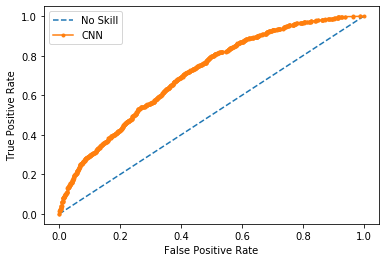

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
auc = 0
acc = 0
ns_probs = [0 for _ in range(len(test_loader.dataset))]
lr_probs = []
testy = []
with torch.no_grad():
    net.eval()
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        testy.extend(labels)
        lr_probs.extend(sigmoid(outputs.cpu().numpy()))

lr_probs = [x[1].item() for x in lr_probs]
testy = [x.item() for x in testy]

ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
print("No Skill AUC: {}".format(ns_auc))
print("Our AUC: {}".format(lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='CNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


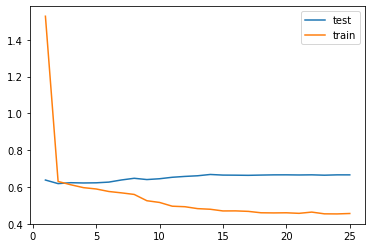

In [0]:
epochs = list(range(1, 26))
plt.plot(epochs, [x for x in test_losses], label="test")
plt.plot(epochs, [x for x in losses], label="train")
plt.legend()
plt.show()